In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

The next is an example of how Moran process works, we are based in: https://apoorvalal.github.io/computation_notes/mathecon/vk/12-Moran-processes.html. This its the most simple Moran process we will use this code of the basis.

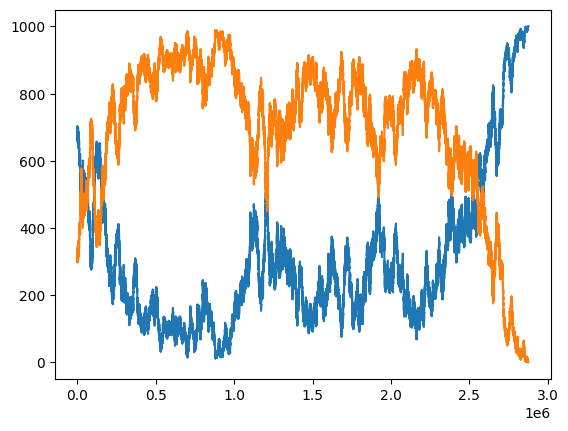

In [10]:
def neutral_moran(N, i):
    """
    Return the population counts for the Moran process with neutral drift.
    """
    population = [0 for _ in range(N-i)] + [1 for _ in range(i)] #Create a list
    counts = [(population.count(0), population.count(1))]
    while len(set(population)) == 2:
        reproduce_index = np.random.randint(N)
        eliminate_index = np.random.randint(N)
        population[eliminate_index] = population[reproduce_index]
        counts.append((population.count(0), population.count(1)))
    return counts
N = 1000
result=neutral_moran(N=N, i=300)
plt.plot(result);


Now, we will define a function that calculates the Shannon index to quantify the clonal diversity within the population. This computation will be performed at each time step of the simulation, allowing us to track how diversity evolves over time. The formula is as follow:
$-Σ_{i=1}p_i\ln p_i$ where $p_i=n_i/N.$

In [11]:
def Sdiversity(counts,N):
  H=[]
  for i in range(len(counts)-1):
    sum=0
    for j in range(len(counts[i])-1):
      if counts[i][j]!=0: #We are saving the case were is no population of one type of cell
        n_i=counts[i][j]
        p_i=n_i/N
        sum+=p_i*np.log(p_i)
    H.append(-sum)
  return H

An example of how our previously defined function works in the first Moran process is shown below:

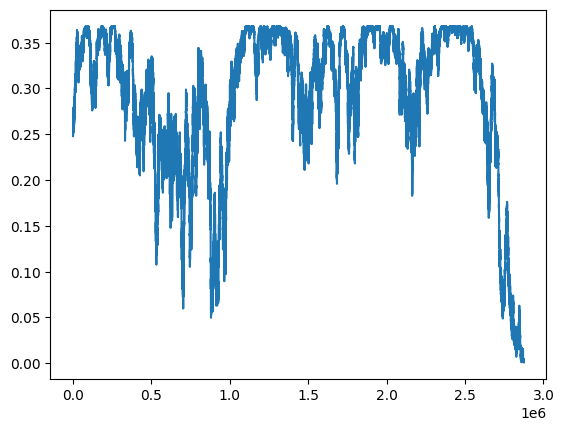

In [12]:
Shanon=Sdiversity(result,N)
plt.plot(Shanon);

To begin our project, we will implement the model following its full details, but without including the treatment component. This will allow us to establish a baseline for comparison in the later stages of the analysis.

In [14]:
"""
For of all we will define a function ver useful before
we construct our codes for the Moran process
"""
def probabilities(fitness, population):
    # Get the unique cell types in the population
    unique_sorted = sorted(set(population))

    # Calculate the total sum of the weighted counts of each cell type
    total = sum(fitness[i] * population.count(unique_sorted[i]) for i in range(len(unique_sorted)))

    # Calculate the probability for each cell type
    prob = [(fitness[i] * population.count(unique_sorted[i])) / total for i in range(len(unique_sorted))]

    return prob

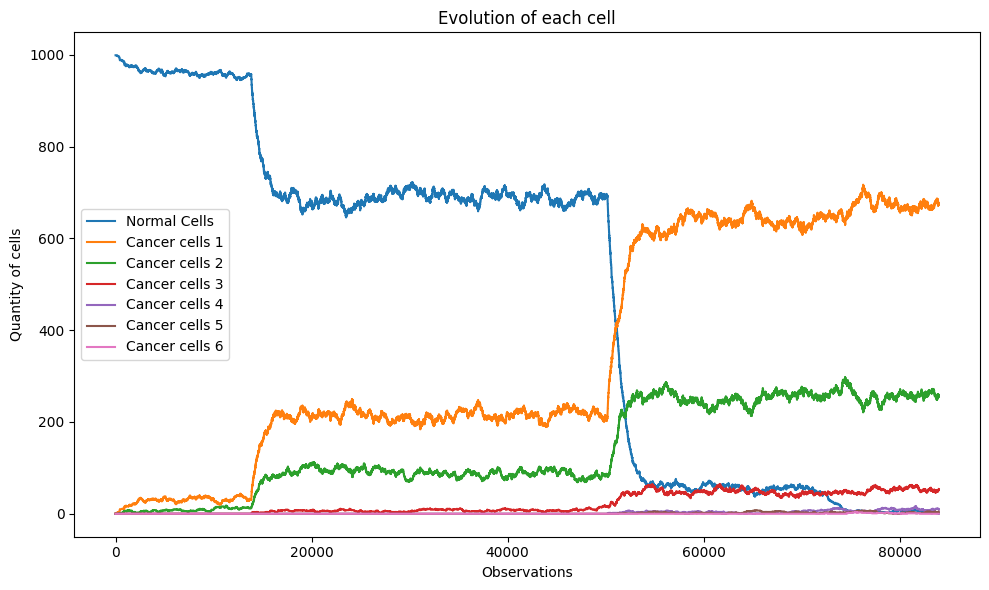

In [18]:
def moran(N, i,tmax,mu):
    """
    Return the population counts for the Moran process with fitness and mutation rate
    """
    ######################### INITIAL VALUES ###############################
    mu_n=0.001 #The mutation rate of the normal cell
    mu_c=mu #The mutation rate of the cancer cells
    f_n=1 #The fitness of the normal cells
    f_c=10 #The fitness of the cancer cells
    population = [0 for _ in range(N-i)] + [1 for _ in range(i)] #Create an initial list
    """
    0 is for the normal cells and 1 for the cancer cells
    """
    counts = [(population.count(0), population.count(1))] #Count de quantity of 0 and 1
    fitness=[1,10] #The fitness of the previous types of cells
    mutation_rate={0: mu_n, 1: mu_c }  #The mutation rate of the previous types of cells
    prob=probabilities(fitness,population) #Compute each probability for each type of cell
    type_cells=sorted(set(population))#Create a list with each cell in the population
    t=1
    ######################### MORAN PROCESS ###############################
    while counts[-1][0] != 0 and counts[-1][0] != N and t!=tmax: #It will stop when the number of normal cells is 0 (dead) or N (recovery) or t=tmax
      """
      At first we need to reproduce some cell, and we will see the type of cell
      """
      celltype_choice = random.choices(type_cells, weights=prob)[0] #Choose the type of cell for reproduce and see if this will mutate
      population=population+[celltype_choice] #We add the new cell in the population
      """
      We will determinate if the mutation occurs for the cell that we choice
      """
      mutation = random.choices([True, False], weights=[mutation_rate[celltype_choice], 1 - mutation_rate[celltype_choice]])[0]
      maxnum=max(population) #For know if there are a new type of cancer cell
      if mutation: #We need to do many things in this case
        index = population.index(celltype_choice)  # Find first occurrence of the type of cell we want
        population[index]=population[index]+1 #We are doing the instrucction of c'=C+1
      #If there are new mutations we need to add a new fitness and mutation rate
        if max(population) > maxnum:
           maxnum= max(population) #Update the maxnum
           if maxnum>max(type_cells): ##Exist the case that we kill the maximum and we already have it in the type of cells
            """
            Exist the case that we delete the new cell we have, so its better refresh
            the type of cells and the other things that we have at later
            """
            eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
            del population[eliminate_index]  # Deletes the cell we choose
            type_cells=sorted(set(population))
            if max(type_cells)==maxnum:
              mutation_rate[maxnum]=mu_c #This doesnt change because the tratment afect only the frecuency
              fitness=fitness+[f_c] #For simplicity all the frecuencies will be alpha*10 except in normal cells
              "Before to add the new array with another dimension, its necessary to fix the problem of dimension with the others lists"
              for n in range(len(counts)):
                counts[n]=counts[n]+(0,)
            prob=probabilities(fitness,population) #Its neccesary change the probabilities because we have a new type of cell
            counts.append(())
            for types in range(max(type_cells)+1):
              counts[-1]=counts[-1]+(population.count(types),) #We are adding the result in the list for the plot
           else:
            eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
            del population[eliminate_index]  # Deletes the cell we choose
            counts.append(())
            for types in range(max(type_cells)+1):
              counts[-1]=counts[-1]+(population.count(types),)
        else:
          eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
          del population[eliminate_index]  # Deletes the cell we choose
          counts.append(())
          for types in range(max(type_cells)+1):
            counts[-1]=counts[-1]+(population.count(types),)
      else:
        eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
        del population[eliminate_index]  # Deletes the cell we choose
        counts.append(())
        for types in range(max(type_cells)+1):
          counts[-1]=counts[-1]+(population.count(types),)
      t+=1
    return counts
########################## PLOT ######################################
N = 1000
Ncancer=1
tmax=100000
mu=0.01 #for the experiment this will be more comfortable
result=moran(N=N, i=Ncancer, tmax= tmax, mu=mu)
# We will generate dynamics labels
labels =["Normal Cells"] + [f"Cancer cells {i}" for i in range(1, len(result[0]))]
# We will use
plt.figure(figsize=(10, 6))
plt.plot(result, label=labels)
plt.xlabel("Observations")
plt.ylabel("Quantity of cells")
plt.title("Evolution of each cell")
plt.legend()
plt.tight_layout()
plt.show()

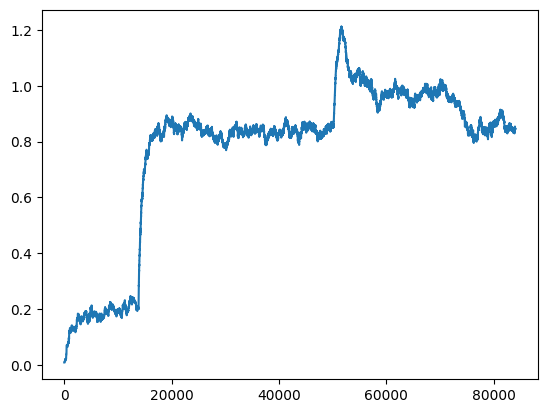

In [19]:
Shanon=Sdiversity(result,N)
plt.plot(Shanon);

Now it is necessary to observe what happens when treatment is introduced. In this case, we use flags within the while loops to ensure consistency in the simulation process. This is important because, once the cancer is detected, the system should transition to a treatment state and remain there—without reverting to the untreated state.

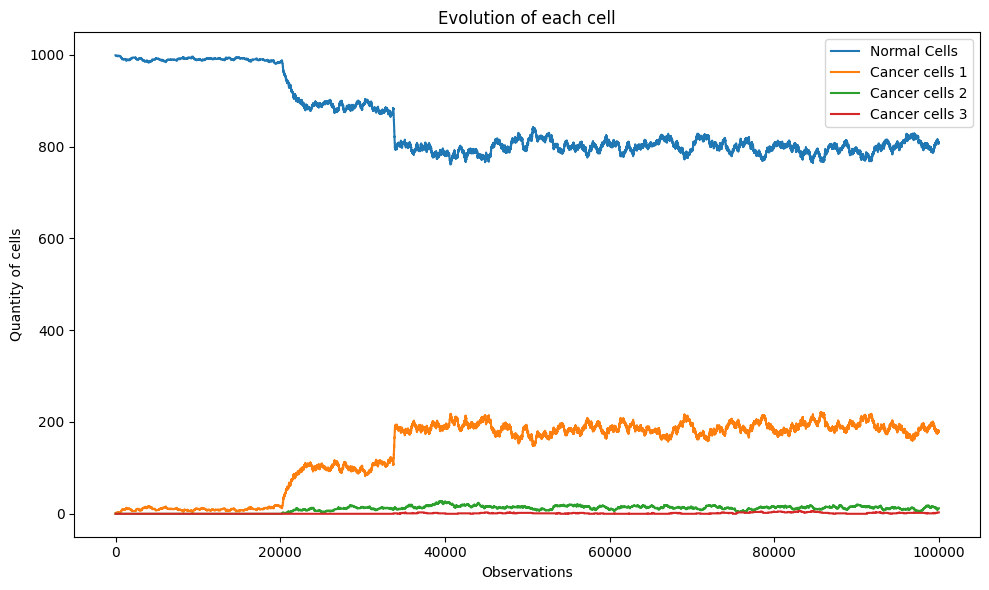

In [26]:
def moran_treatment(N, i,tmax, alpha, omega, mu): #Omega its for the cancer detection and alpha its for the treatment
    ######################### INITIAL VALUES ###############################
    mu_n=0.001
    mu_c=mu
    f_n=1
    f_c=10
    population = [0 for _ in range(N-i)] + [1 for _ in range(i)] #Create an initial list
    counts = [(population.count(0), population.count(1))] #Count de quantity of 0 and 1
    fitness=[f_n,f_c] #The fitness of the previous types of cells
    mutation_rate={0: mu_n, 1: mu_c }  #The mutation rate of the previous types of cells
    prob=probabilities(fitness,population)
    type_cells=sorted(set(population))
    ######################### MORAN PROCESS WITHOUT TREATMENT ################
    flag1=True #with this flag we will can see if the person it is in treatment
    'If flag1=False its because we find the condition to begin the treatment'
    flag2=True #with this flag we will can see if the code is with normal cells equal N or cancer cell equal zero or t=tmax
    t=0
    while flag1 and flag2: #It will stop when the number of normal cells is 0 (dead) or N (recovery) or t=tmax
      """
      At first we need to reproduce some cell, at first we will see the type of cell
      """
      celltype_choice = random.choices(type_cells, weights=prob)[0]
      population=population+[celltype_choice]
      """
      We will determinate if the mutation occurs for the cell that we choice
      """
      mutation = random.choices([True, False], weights=[mutation_rate[celltype_choice], 1 - mutation_rate[celltype_choice]])[0]
      maxnum=max(population) #For know if there are a new type of cancer cell

      if mutation: #We need to do many things
        index = population.index(celltype_choice)  # Find first occurrence of the type of cell we want
        population[index]=population[index]+1
      #If there are new mutations we need to add a new fitness and mutation rate
        if max(population) > maxnum:
           maxnum= max(population) #Update the maxnum
           if maxnum>max(type_cells): ##Exist the case that we kill the maximum and we already have it in the type of cells
            """
            Exist the case that we delete the new cell we have, so its better refresh
            the type of cells and the other things that we have at later
            """
            eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
            del population[eliminate_index]  # Deletes the cell we choose
            type_cells=sorted(set(population))
            if max(type_cells)==maxnum:
              mutation_rate[maxnum]=mu_c #This doesnt change because the tratment afect only the frecuency
              fitness=fitness+[f_c] #For simplicity all the frecuencies will be alpha*10 except in normal cells
              "Before to add the new array with another dimension, its necessary to fix the problem of dimension with the others lists"
              for n in range(len(counts)):
                counts[n]=counts[n]+(0,)
            prob=probabilities(fitness,population) #Its neccesary change the probabilities because we have a new type of cell
           counts.append(())
           for types in range(max(type_cells)+1):
            counts[-1]=counts[-1]+(population.count(types),)
        else:
          eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
          del population[eliminate_index]  # Deletes the cell we choose
          counts.append(())
          for types in range(max(type_cells)+1):
            counts[-1]=counts[-1]+(population.count(types),)
      else:
        eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
        del population[eliminate_index]  # Deletes the cell we choose*
        counts.append(())
        for types in range(max(type_cells)+1):
          counts[-1]=counts[-1]+(population.count(types),)
      if counts[-1][0] == 0 or counts[-1][0] == N or t==tmax: #We are seeing if the code meet the previous conditions
        flag1=False
      if (N*(1-omega)-counts[-1][0]) > 0: #The condition for know if the cancer is detectable
        flag2=False #We exit the loop
      t+=1
    #But we need to change the flag 2 in case they detect the cancer to begin the treatment and we are usign another loop because its necessary dont return to the not treatment state
    #If the flag 1 is False, we wont enter in the next loop because we are already done
    ######################### MORAN PROCESS WITH TREATMENT ################
    """
    At first we need to change the fitness of each cancer cells if we will begin the treatment so
    """
    if flag2==False:
      for j in range (1,len(fitness)):
        fitness[j]=alpha*fitness[j]
      type_cells=sorted(set(population))
      prob=probabilities(fitness,population)
    """
    The code will not enter the while loop if flag1 is set to False, and the execution will end.
    """
    while flag1: #It will stop when the number of normal cells is 0 (dead) or N (recovery) or t=tmax
      """
      Then we need to reproduce some cell, at first we will see the type of cell
      """
      celltype_choice = random.choices(type_cells, weights=prob)[0]
      population=population+[celltype_choice]
      """
      We will determinate if the mutation occurs for the cell that we choice
      """
      mutation = random.choices([True, False], weights=[mutation_rate[celltype_choice], 1 - mutation_rate[celltype_choice]])[0]
      maxnum=max(population) #For know if there are a new type of cancer cell
      if mutation: #We need to do many things
        index = population.index(celltype_choice)  # Find first occurrence of the type of cell we want
        population[index]=population[index]+1
      #If there are new mutations we need to add a new fitness and mutation rate
        if max(population) > maxnum:
           maxnum= max(population) #Update the maxnum
           if maxnum>max(type_cells): ##Exist the case that we kill the maximum and we already have it in the type of cells
            """
            Exist the case that we delete the new cell we have, so its better refresh
            the type of cells and the other things that we have at later
            """
            eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
            del population[eliminate_index]  # Deletes the cell we choose
            type_cells=sorted(set(population))
            if max(type_cells)==maxnum:
              mutation_rate[maxnum]=mu_c #This doesnt change because the tratment afect only the frecuency
              fitness=fitness+[alpha*f_c] #For simplicity all the frecuencies will be alpha*10 except in normal cells
              "Before to add the new array with another dimension, its necessary to fix the problem of dimension with the others lists"
              for n in range(len(counts)):
                counts[n]=counts[n]+(0,)
            prob=probabilities(fitness,population) #Its neccesary change the probabilities because we have a new type of cell
           counts.append(())
           for types in range(max(type_cells)+1):
            counts[-1]=counts[-1]+(population.count(types),)
        else:
          eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
          del population[eliminate_index]  # Deletes the cell we choose
          counts.append(())
          for types in range(max(type_cells)+1):
            counts[-1]=counts[-1]+(population.count(types),)
      else:
        eliminate_index = np.random.randint(N) #We can use randint because we have all the population in a list
        del population[eliminate_index]  # Deletes the cell we choose
        counts.append(())
        for types in range(max(type_cells)+1):
          counts[-1]=counts[-1]+(population.count(types),)
      t+=1
      if counts[-1][0] == 0 or counts[-1][0] == N or t==tmax: #We are seeing if the code meet the previous conditions
        flag1=False
    return counts
########################## PLOT ######################################
N = 1000
tmax=100000
Ncancer=1
alpha=0.1
omega=0.2
mu=0.01
result=moran_treatment(N=N, i=Ncancer, tmax= tmax, alpha=alpha, omega=omega, mu=mu)
# We will generate dynamics labels
labels =["Normal Cells"] + [f"Cancer cells {i}" for i in range(1, len(result[0]))]
plt.figure(figsize=(10, 6))
plt.plot(result, label=labels)
plt.xlabel("Observations")
plt.ylabel("Quantity of cells")
plt.title("Evolution of each cell")
plt.legend()
plt.tight_layout()
plt.show()


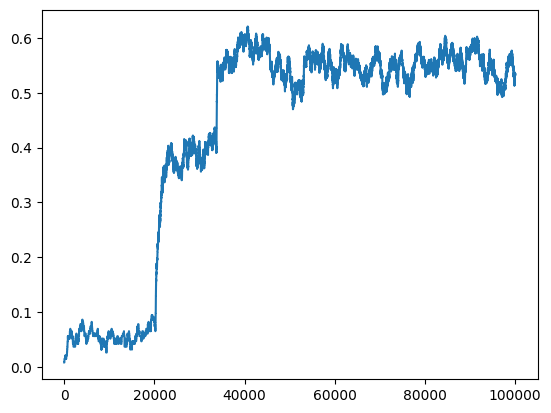

In [27]:
Shanon=Sdiversity(result,N)
plt.plot(Shanon);

Now, we need to establish an experimental protocol to assess the impact of genetic instability on cancer development and the effectiveness of treatment. To do this, we will test different mutation rates in cancer cells. Initially, we will analyze the area under the curve (AUC) for the cancer cells across multiple iterations with varying mutation rates. Additionally, we will examine the final Shannon index for each iteration and observe how its graph evolves over time for each set of conditions.

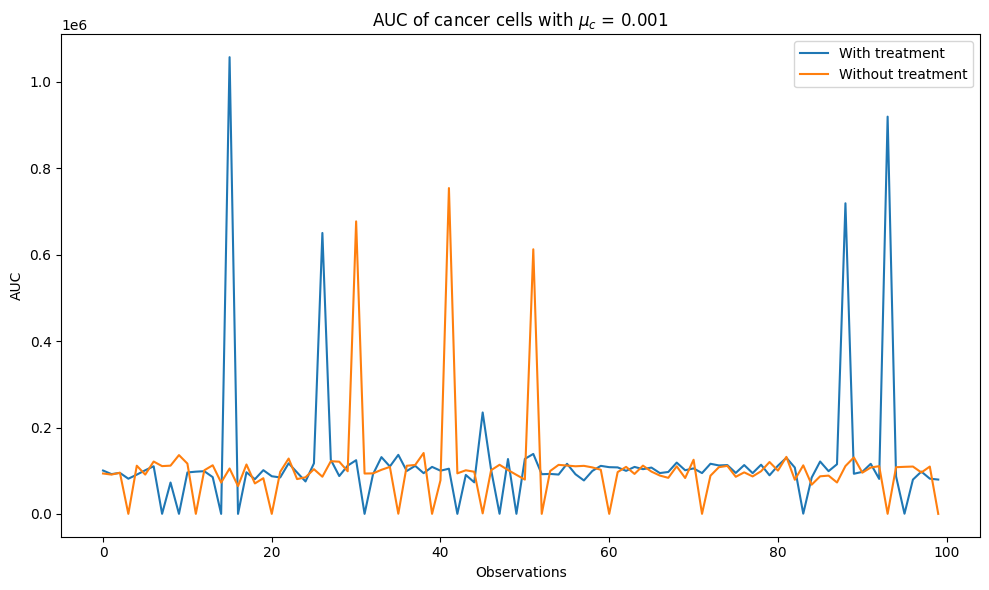

In [28]:
"""
For see the impact of the genetic instability in the development of cancer we will
compare the AUC of cancer cell and the diversity for diferents values of mu.
We begin using a value of mu=0.001
"""
N = 1000; tmax=10000; Ncancer=1; alpha=0.1; omega=0.2; iter=100;
mu1=0.001; mu2=0.01; mu3=0.1; mu4=0.5;
AUC_mu1=[];AUC_mu2=[];AUC_mu3=[];AUC_mu4=[];
Shanon_mu1=[];Shanon_mu2=[];Shanon_mu3=[];Shanon_mu4=[];
for i in range(iter):
  AUC_nt=0 #The total AUC for every cancer cell for the moran process without treatment
  AUC_t=0 #The total AUC for every cancer cell for the moran process with treatment
  treatment=moran_treatment(N,Ncancer,tmax,alpha,omega,mu1)
  shanon_t=Sdiversity(treatment,N)[-1] #We well use the final value for simplicity
  nottreatment=moran(N,Ncancer,tmax,mu1)
  shanon_nt=Sdiversity(nottreatment,N)[-1] #We well use the final value for simplicity
  Shanon_mu1.append((shanon_t,shanon_nt))
  for j in range(1,len(nottreatment[0])):
    AUC_nt=AUC_nt+np.trapezoid(np.array(nottreatment)[:,j]) #We are summing the area under the curve of each cancer cell
  for t in range(1,len(treatment[0])):
    AUC_t=AUC_t+np.trapezoid(np.array(treatment)[:,t]) #The same here
  AUC_mu1.append((AUC_t.tolist(),AUC_nt.tolist()))
############################### PLOT #####################################
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(AUC_mu1, label=labels)
plt.xlabel("Observations")
plt.ylabel("AUC")
plt.title(f"AUC of cancer cells with $\\mu_c$ = {mu1}")
plt.legend()
plt.tight_layout()
plt.show()

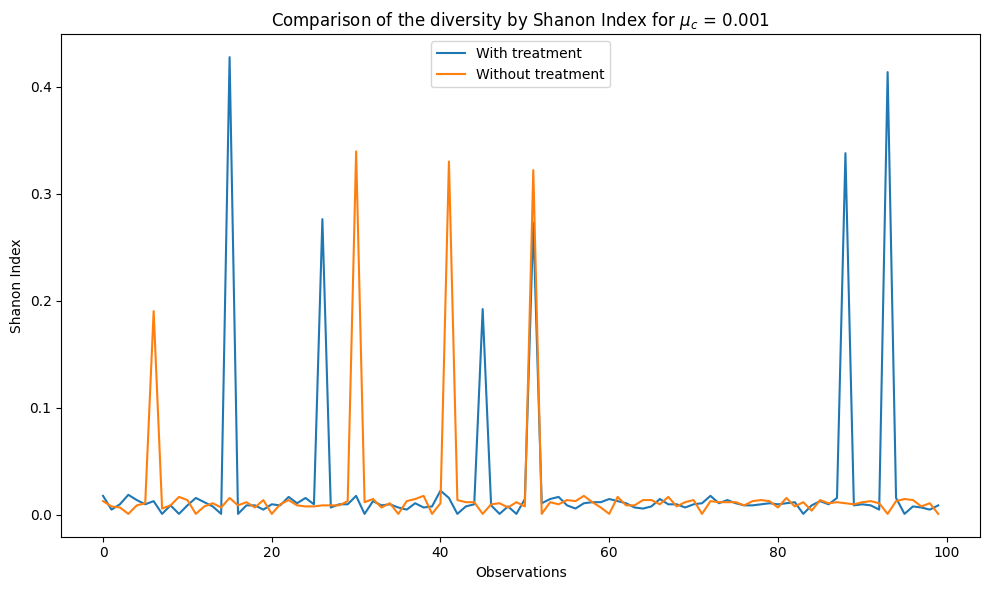

In [29]:
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(Shanon_mu1, label=labels)
plt.xlabel("Observations")
plt.ylabel("Shanon Index")
plt.title(f"Comparison of the diversity by Shanon Index for $\\mu_c$ = {mu1}")
plt.legend()
plt.tight_layout()
plt.show()

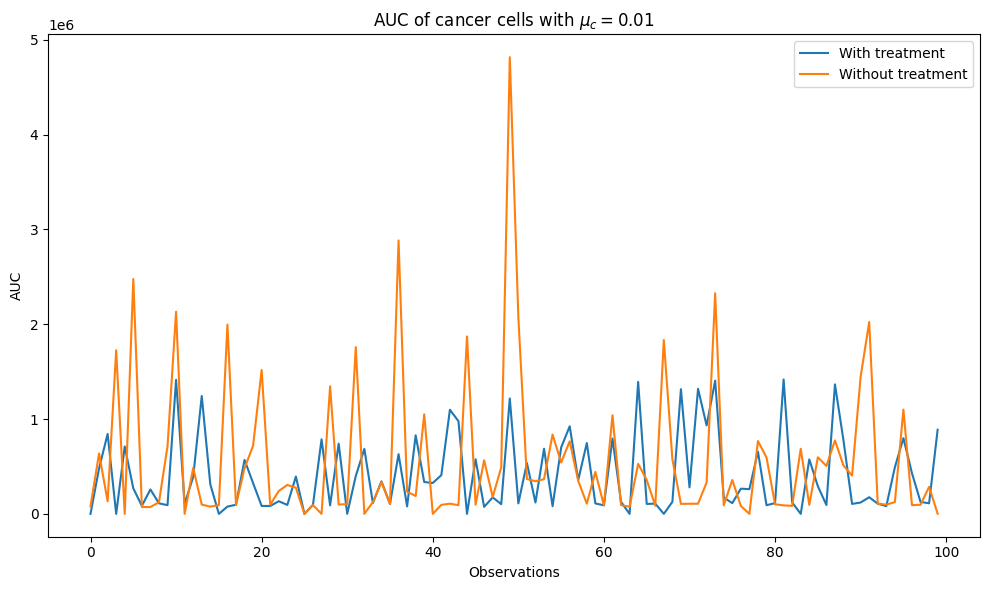

In [30]:
"""
We use a value of mu=0.01
"""
for i in range(iter):
  AUC_nt=0 #The total AUC for every cancer cell for the moran process without treatment
  AUC_t=0 #The total AUC for every cancer cell for the moran process with treatment
  treatment=moran_treatment(N,Ncancer,tmax,alpha,omega,mu2)
  shanon_t=Sdiversity(treatment,N)[-1] #We well use the final value for simplicity
  nottreatment=moran(N,Ncancer,tmax,mu2)
  shanon_nt=Sdiversity(nottreatment,N)[-1] #We well use the final value for simplicity
  Shanon_mu2.append((shanon_t,shanon_nt))
  for j in range(1,len(nottreatment[0])):
    AUC_nt=AUC_nt+np.trapezoid(np.array(nottreatment)[:,j]) #We are summing the area under the curve of each cancer cell
  for t in range(1,len(treatment[0])):
  # The next part is to fix an error that arose due to the AUC code related to the array dimensions.
    max_len = max(len(row) for row in treatment)
    treatment_fixed = [list(row) + [0]*(max_len - len(row)) for row in treatment]
    AUC_t=AUC_t+np.trapezoid(np.array(treatment_fixed)[:,t]) #The same here
  AUC_mu2.append((AUC_t.tolist(),AUC_nt.tolist()))
############################### PLOT #####################################
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(AUC_mu2, label=labels)
plt.xlabel("Observations")
plt.ylabel("AUC")
plt.title(f"AUC of cancer cells with $\\mu_c= {mu2}$")
plt.legend()
plt.tight_layout()
plt.show()

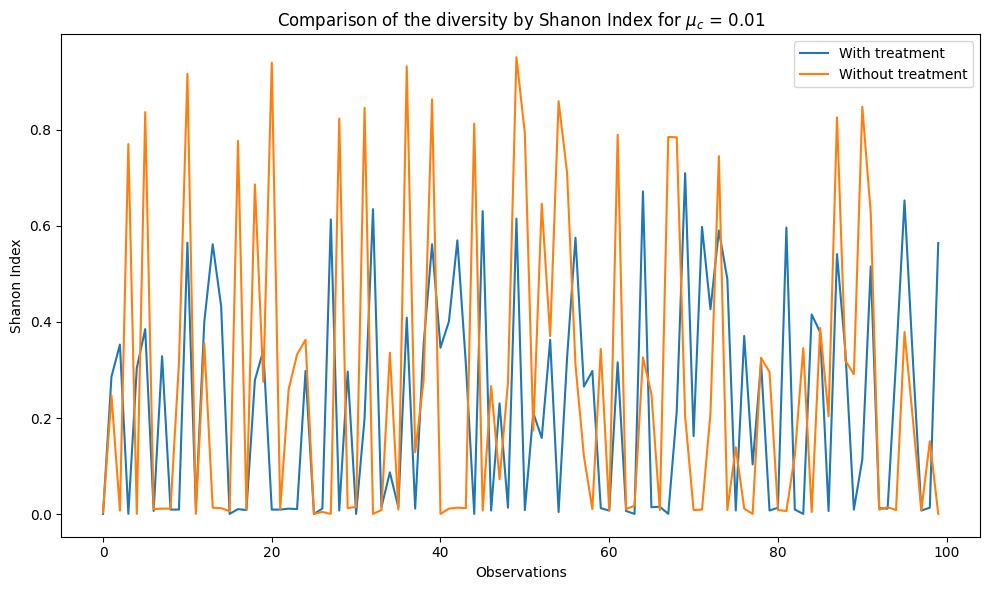

In [31]:
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(Shanon_mu2, label=labels)
plt.xlabel("Observations")
plt.ylabel("Shanon Index")
plt.title(f"Comparison of the diversity by Shanon Index for $\\mu_c$ = {mu2}")
plt.legend()
plt.tight_layout()
plt.show()

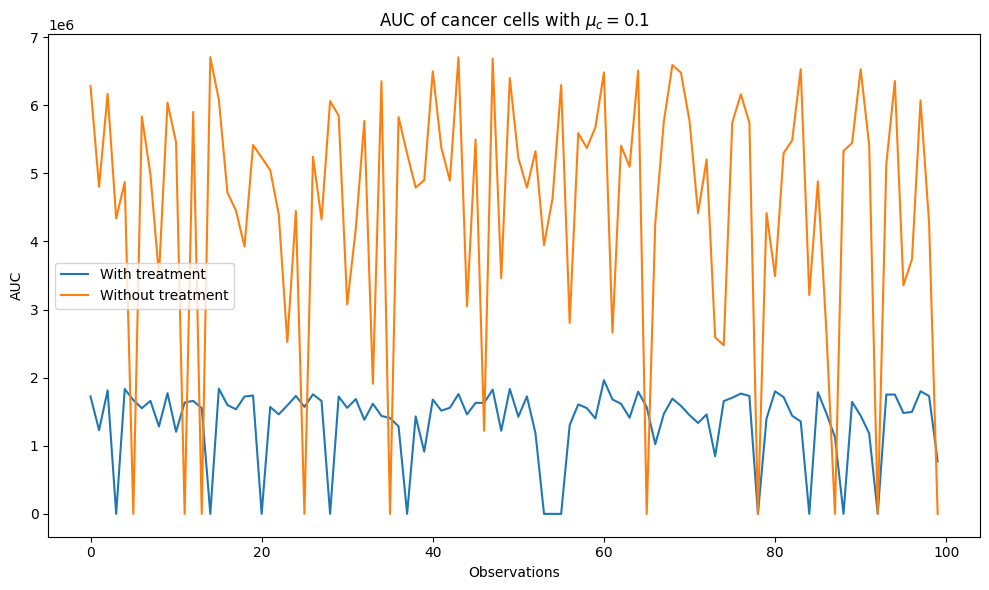

In [32]:
"""
We use a value of mu=0.1
"""
for i in range(iter):
  AUC_nt=0 #The total AUC for every cancer cell for the moran process without treatment
  AUC_t=0 #The total AUC for every cancer cell for the moran process with treatment
  treatment=moran_treatment(N,Ncancer,tmax,alpha,omega,mu3)
  shanon_t=Sdiversity(treatment,N)[-1] #We well use the final value for simplicity
  nottreatment=moran(N,Ncancer,tmax,mu3)
  shanon_nt=Sdiversity(nottreatment,N)[-1] #We well use the final value for simplicity
  Shanon_mu3.append((shanon_t,shanon_nt))
  for j in range(1,len(nottreatment[0])):
    AUC_nt=AUC_nt+np.trapezoid(np.array(nottreatment)[:,j]) #We are summing the area under the curve of each cancer cell
  for t in range(1,len(treatment[0])):
  # The same for this
    max_len = max(len(row) for row in treatment)
    treatment_fixed = [list(row) + [0]*(max_len - len(row)) for row in treatment]
    AUC_t=AUC_t+np.trapezoid(np.array(treatment_fixed)[:,t]) #The same here
  AUC_mu3.append((AUC_t.tolist(),AUC_nt.tolist()))
############################### PLOT #####################################
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(AUC_mu3, label=labels)
plt.xlabel("Observations")
plt.ylabel("AUC")
plt.title(f"AUC of cancer cells with $\\mu_c= {mu3}$")
plt.legend()
plt.tight_layout()
plt.show()

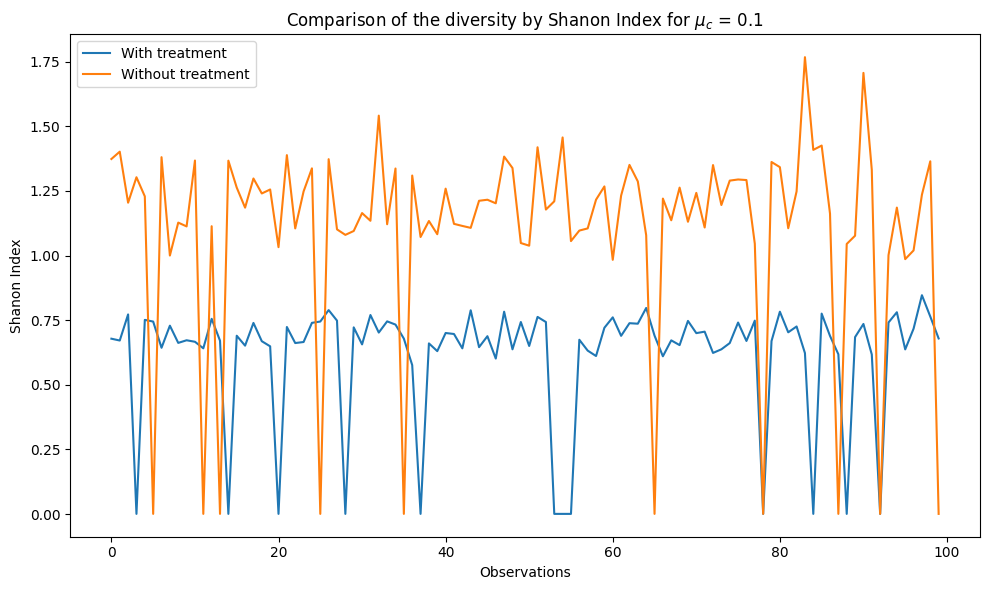

In [33]:
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(Shanon_mu3, label=labels)
plt.xlabel("Observations")
plt.ylabel("Shanon Index")
plt.title(f"Comparison of the diversity by Shanon Index for $\\mu_c$ = {mu3}")
plt.legend()
plt.tight_layout()
plt.show()

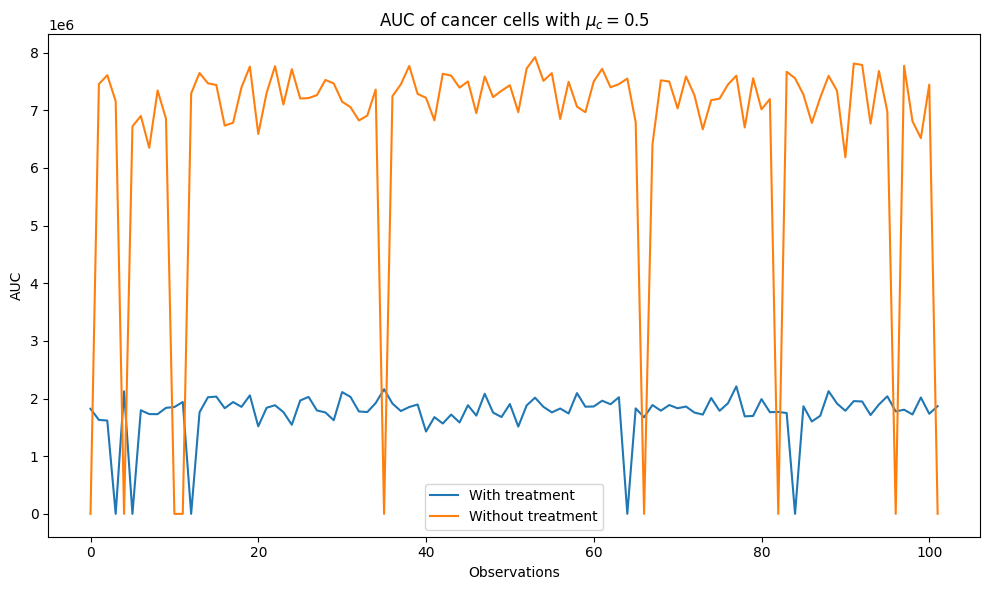

In [35]:
"""
We use a value of mu=0.5
"""
for i in range(iter):
  AUC_nt=0 #The total AUC for every cancer cell for the moran process without treatment
  AUC_t=0 #The total AUC for every cancer cell for the moran process with treatment
  treatment=moran_treatment(N,Ncancer,tmax,alpha,omega,mu4)
  shanon_t=Sdiversity(treatment,N)[-1] #We well use the final value for simplicity
  nottreatment=moran(N,Ncancer,tmax,mu4)
  shanon_nt=Sdiversity(nottreatment,N)[-1] #We well use the final value for simplicity
  Shanon_mu4.append((shanon_t,shanon_nt))
  max_len = max(len(row) for row in treatment)
  # We are fixing the same issue with the AUC in this part as we did in the previous code.
  treatment_fixed = [list(row) + [0]*(max_len - len(row)) for row in treatment]
  treatment_fixed = np.array(treatment_fixed)  # Convertimos a array de verdad
  for j in range(1, len(nottreatment[0])):
    AUC_nt += np.trapezoid(np.array(nottreatment)[:, j])
  for t in range(1, max_len):
    AUC_t += np.trapezoid(treatment_fixed[:, t])
  AUC_mu4.append((AUC_t.tolist(),AUC_nt.tolist()))
############################### PLOT #####################################
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(AUC_mu4, label=labels)
plt.xlabel("Observations")
plt.ylabel("AUC")
plt.title(f"AUC of cancer cells with $\\mu_c= {mu4}$")
plt.legend()
plt.tight_layout()
plt.show()

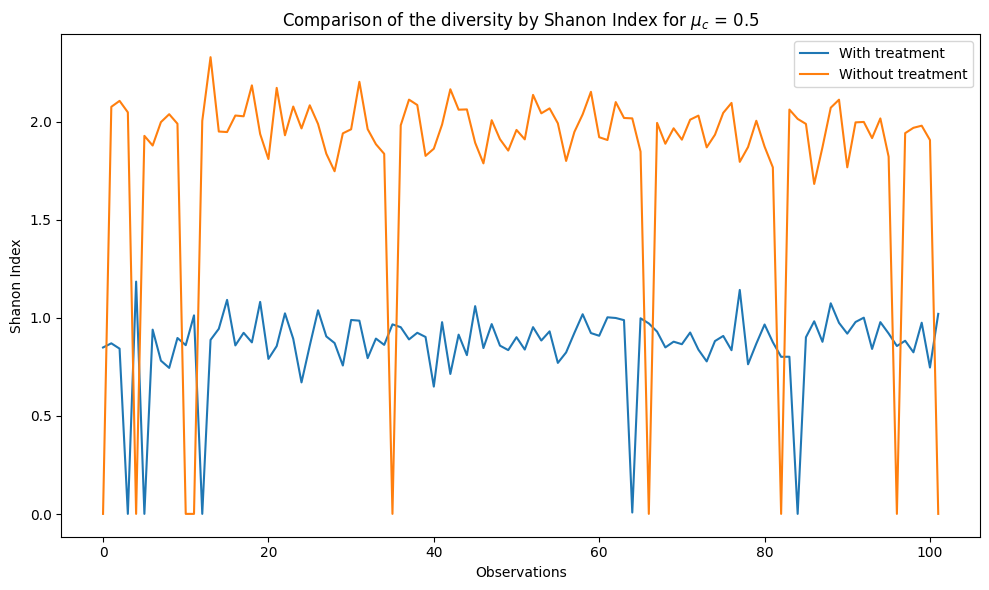

In [36]:
plt.figure(figsize=(10, 6))
labels=["With treatment", "Without treatment"]
plt.plot(Shanon_mu4, label=labels)
plt.xlabel("Observations")
plt.ylabel("Shanon Index")
plt.title(f"Comparison of the diversity by Shanon Index for $\\mu_c$ = {mu4}")
plt.legend()
plt.tight_layout()
plt.show()